In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# 定义 ANN 模型（确保在使用前定义）
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 12)
        self.layer2 = nn.Linear(12, 24)
        self.layer3 = nn.Linear(24, 60)
        self.layer4 = nn.Linear(60, 120)
        self.layer5 = nn.Linear(120, 12)
        self.output = nn.Linear(12, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = self.output(x)
        return x

# 自定义 MAPE 损失函数
class MAPE_Loss(nn.Module):
    def __init__(self):
        super(MAPE_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # 避免除零
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

Epoch [10/1000], Loss: 27.3069
Epoch [20/1000], Loss: 22.3601
Epoch [30/1000], Loss: 17.9079
Epoch [40/1000], Loss: 15.1333
Epoch [50/1000], Loss: 13.6472
Epoch [60/1000], Loss: 11.7777
Epoch [70/1000], Loss: 11.5557
Epoch [80/1000], Loss: 10.4271
Epoch [90/1000], Loss: 9.6366
Epoch [100/1000], Loss: 9.2347
Epoch [110/1000], Loss: 9.1463
Epoch [120/1000], Loss: 8.6867
Epoch [130/1000], Loss: 8.3404
Epoch [140/1000], Loss: 8.1814
Epoch [150/1000], Loss: 8.5903
Epoch [160/1000], Loss: 7.6415
Epoch [170/1000], Loss: 7.3658
Epoch [180/1000], Loss: 7.4674
Epoch [190/1000], Loss: 6.8924
Epoch [200/1000], Loss: 6.7612
Epoch [210/1000], Loss: 7.0393
Epoch [220/1000], Loss: 6.8190
Epoch [230/1000], Loss: 6.5081
Epoch [240/1000], Loss: 6.4187
Epoch [250/1000], Loss: 6.9701
Epoch [260/1000], Loss: 5.9001
Epoch [270/1000], Loss: 6.1250
Epoch [280/1000], Loss: 5.9948
Epoch [290/1000], Loss: 5.8585
Epoch [300/1000], Loss: 6.3712
Epoch [310/1000], Loss: 5.2939
Epoch [320/1000], Loss: 5.8987
Epoch [33

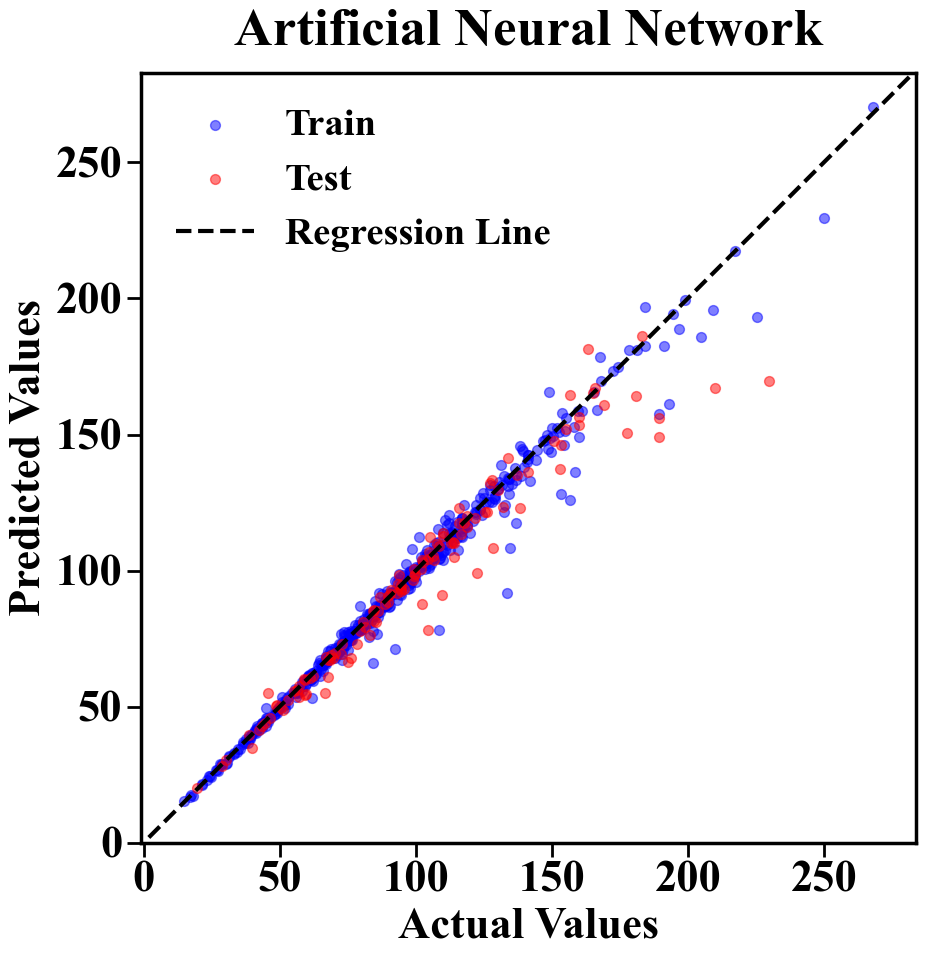

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,ANN,0.980649,2.604259,2.50867,5.479606,0.931869,5.569619,4.727721,10.71608


In [10]:
from function import metrics_to_dataframe, plot_actual_vs_predicted

# 数据准备
data = pd.read_csv("data/dataset.csv")
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop(['Cs', 'target_class'], axis=1).values
y = data['Cs'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型并将其移到 GPU（如果可用）
input_dim = X_train.shape[1]
model = ANN(input_dim).to(device)

# 定义损失函数和优化器
loss_function = MAPE_Loss().to(device)  # 自定义损失函数也要移到 GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # 移动 batch 数据到 GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# 评估模型 (确保在 GPU 上)
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()  # 转换为 CPU 数据，便于后续处理
    y_test_pred = model(X_test_tensor).cpu().numpy()

# 绘制实际 vs 预测图
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'Artificial Neural Network', 'output/figures/ann.png')

# 保存模型
torch.save(model.state_dict(), "ann_model.pth")

# 计算并显示评估指标
ann_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'ANN')
ann_metrics